In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# Create DataFrame from provided dataset
data = {
    "Date": pd.date_range(start="2022-06-19", periods=31, freq='D'),
    "Pods": [3090, 3088, 3088, 3088, 3120, 2910, 1210, 3090, 3088, 3088, 3088, 3120, 
             2910, 1210, 3090, 3088, 3086, 3086, 3120, 2910, 1210, 3100, 3106, 3106, 
             3106, 3120, 2910, 1210, 3120, 3120, 3120]
}
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Pods
Date,
2022-06-19,3090
2022-06-20,3088
2022-06-21,3088
2022-06-22,3088
2022-06-23,3120
2022-06-24,2910
2022-06-25,1210
2022-06-26,3090
2022-06-27,3088


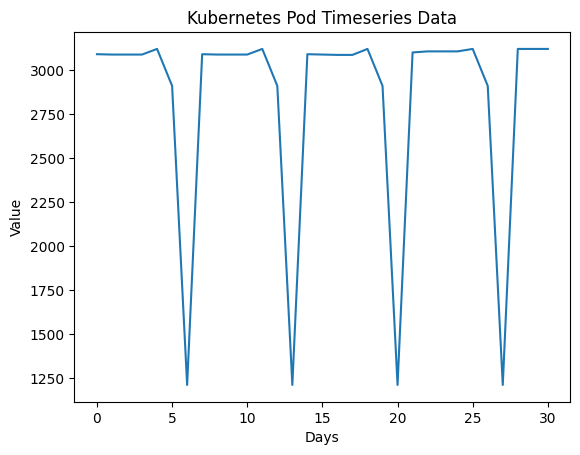

In [3]:
plt.plot(df[['Pods']].values.astype('float32'))
plt.title('Kubernetes Pod Timeseries Data')
plt.xlabel('Days')
plt.ylabel('Value')
plt.show()

In [4]:
data = df['Pods'].values.astype('float32')

In [6]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [11]:
# train-test split for time series
train_size = int(len(data) * 0.70)
test_size = len(data) - train_size
train, test = data[:train_size], data[train_size:]

In [12]:
train

array([3090., 3088., 3088., 3088., 3120., 2910., 1210., 3090., 3088.,
       3088., 3088., 3120., 2910., 1210., 3090., 3088., 3086., 3086.,
       3120., 2910., 1210.], dtype=float32)

In [13]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(np.array(train).reshape(-1,1))
test_scaled = scaler.transform(np.array(test).reshape(-1,1))

In [14]:
lookback=1
X_train, y_train = create_dataset(train_scaled, lookback=lookback)
X_test, y_test = create_dataset(test_scaled, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([20, 1, 1]) torch.Size([20, 1, 1])
torch.Size([9, 1, 1]) torch.Size([9, 1, 1])


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn
    
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [29]:
model = LSTM(input_dim=1, hidden_dim=64, layer_dim=1, output_dim=1)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data_utils.DataLoader(data_utils.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [20]:
for X_batch, y_batch in loader:
    print(X_batch)

tensor([[[0.8901]],

        [[1.0000]],

        [[0.9843]],

        [[0.9843]],

        [[0.0000]],

        [[0.8901]],

        [[0.9832]],

        [[0.9832]]])
tensor([[[1.0000]],

        [[0.9843]],

        [[0.9832]],

        [[0.9822]],

        [[0.9832]],

        [[0.0000]],

        [[0.9832]],

        [[1.0000]]])
tensor([[[0.9822]],

        [[0.9832]],

        [[0.8901]],

        [[0.9832]]])


In [31]:
n_epochs = 2000
for epoch in range(n_epochs):
    
    #train model
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred_rescale = scaler.inverse_transform(y_pred)
        y_train_rescale = scaler.inverse_transform(y_train.reshape(-1,1))
        
        train_rmse = np.sqrt(loss_fn(y_pred_rescale, y_train_rescale))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

/home/server-iss-mbkm/project/docker/LSTM/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/server-iss-mbkm/project/docker/LSTM/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: 'int' object is not callable